If you're a microbial ecologist and you haven't used [phyloseq](http://joey711.github.io/phyloseq/), put away your vintage scarf and thick-rimmed glasses because you are not hip. [phyloseq](http://joey711.github.io/phyloseq/) is the nexus of all that is good in the universe. In this post we'll look at one of the greatest [phyloseq](http://joey711.github.io/phyloseq/) functions, ```psmelt```. ```psmelt``` combines your sample info, OTU counts, and taxonomic annotations into a single dataframe where every row represents an OTU-sample combination. Hhhhwhat!?! Amazing, I know. From this omnipotent dataframe you can do anything. So, how do we use ```psmelt```? And can we re-create ```psmelt``` with [dplyr](https://github.com/hadley/dplyr) and [tidyr](https://github.com/hadley/tidyr)?

Let's start by bringing in some R packages and loading the ```rmagic``` extension for IPython. 

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(dplyr); library(tidyr)
library(magrittr)
library(ggplot2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Use suppressPackageStartupMessages to eliminate package startup messages.


I'm going to use data from a paper we recently submitted. See the pre-print [here](http://dx.doi.org/10.1101/013813
) if you're interested. A typical microbiome data set consists of three tables:

1. A table of sample information.
1. A table of OTU counts in the samples.
1. A table of taxonomic info for each OTU.

In this example the OTU counts and taxonomic info are combined in a json [biom](http://biom-format.org/) formatted table. We have the sample information in a [QIIME](http://qiime.org/) formatted sample metadata table. Don't get bogged down in the file formats, however. They're just tables and you can get tables into R easily. Focus on the concepts and what information you need to do an analysis.

We'll write a quick function to handle the [QIIME](http://qiime.org/) formatted sample data table (**note how we're just using the base R ```read.table``` function**) and we'll use the ```import_biom``` function from [phyloseq](http://joey711.github.io/phyloseq/) to import our OTU counts and OTU taxonomic annotations. We'll combine all the info into a ```phyloseq object```. 

In [3]:
%%R
read.qiime = function(fn) {
    read.table(fn, sep = "\t", comment = "", header = TRUE, stringsAsFactors = FALSE) %>%
    rename(SampleID = X.SampleID) %>%
    {rownames(.) = .$SampleID; .} %>%
    data.frame %>% sample_data
}

physeq = import_biom("data/otu_table_wtax.biom")
sample_data(physeq) = read.qiime("data/sample_data_combined_qiime_format.tsv")
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4340 taxa and 158 samples ]
sample_data() Sample Data:       [ 158 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4340 taxa by 8 taxonomic ranks ]


Great! Now let's **melt** all that information into an **all-powerful, all-knowing, benevolent** dataframe. (Evil laugh)

In [4]:
%%R
mdf = psmelt(physeq)
mdf %>% select(OTU, SampleID, Abundance) %>% head

              OTU  SampleID Abundance
20025    OTU.1106 4502024.3      2233
288    DQ531697.1    site16      2147
19962    OTU.1106    site19      1505
272    DQ531697.1    site15      1426
310    DQ531697.1    site17      1278
456836     OTU.36    site19      1268


To keep this post short, I won't demonstrate where you can go from a melted ```phyloseq object```. Suffice to say that you can go anywhere with your melted ```phyloseq object```/dataframe. Think of it like a [magic carpet](https://www.youtube.com/watch?v=qJJog4BJrUw).

With really big OTU tables, melting can take a long time...

In [5]:
%%R
system.time(psmelt(physeq))

   user  system elapsed 
 22.660   0.056  22.728 


It takes about 30-ish seconds with our example phyloseq object with the ```psmelt``` function. I wonder how fast [dplyr](https://github.com/hadley/dplyr) + [tidyr](https://github.com/hadley/tidyr) can melt our phyloseq object?

Let's re-create the ```psmelt``` function with [dplyr](https://github.com/hadley/dplyr) + [tidyr](https://github.com/hadley/tidyr).

We need to,

1. get our tables (sample data, OTU counts, taxonomy),
1. combine our taxonomic info with our OTU counts,
1. gather this combined table into a long form version, and
1. add in the sample data.

In [6]:
%%R
psmelt.dplyr = function(physeq) {
    sd = data.frame(sample_data(physeq))
    TT = data.frame(tax_table(physeq)) %>% add_rownames("OTU")
    otu.table = data.frame(otu_table(physeq), check.names = FALSE) %>% add_rownames("OTU")
    otu.table %>%
        left_join(TT) %>%
        gather_("SampleID", "Abundance", setdiff(colnames(otu.table), "OTU")) %>%
        left_join(sd)
}

In [7]:
%%R
mdf.dplyr = psmelt.dplyr(physeq)
mdf.dplyr %>% select(OTU, SampleID, Abundance) %>% head

Joining by: "OTU"
Joining by: "SampleID"
       OTU SampleID Abundance
1  OTU.758    G4F20         2
2 OTU.2942    G4F20         0
3  OTU.753    G4F20         0
4  OTU.752    G4F20         0
5  OTU.751    G4F20         0
6  OTU.750    G4F20         0


...and let's see how fast it is.

In [8]:
%%R
system.time(psmelt.dplyr(physeq))

Joining by: "OTU"
Joining by: "SampleID"
   user  system elapsed 
   1.04    0.00    1.04 


**Wow. Roughly an order of magnitude faster. dplyr and tidyr are so great. And look at that syntax!**

I shold note that I'm using phyloseq version **1.9.15** in this demo.

The ```psmelt``` function is so useful (and much more rigorous/fool-proof than our quick dplyr/tidyr version) but if you have a huge phyloseq object that takes forever to melt, try dplyr + tidyr.

Let's do one quick example from the melted ```phyloseq object``` to give you a taste of how useful it is. Let's say we want to make phylum level stacked bar charts for all the studies in the example data. Here's how you might do it from the melted ```phyloseq object```.

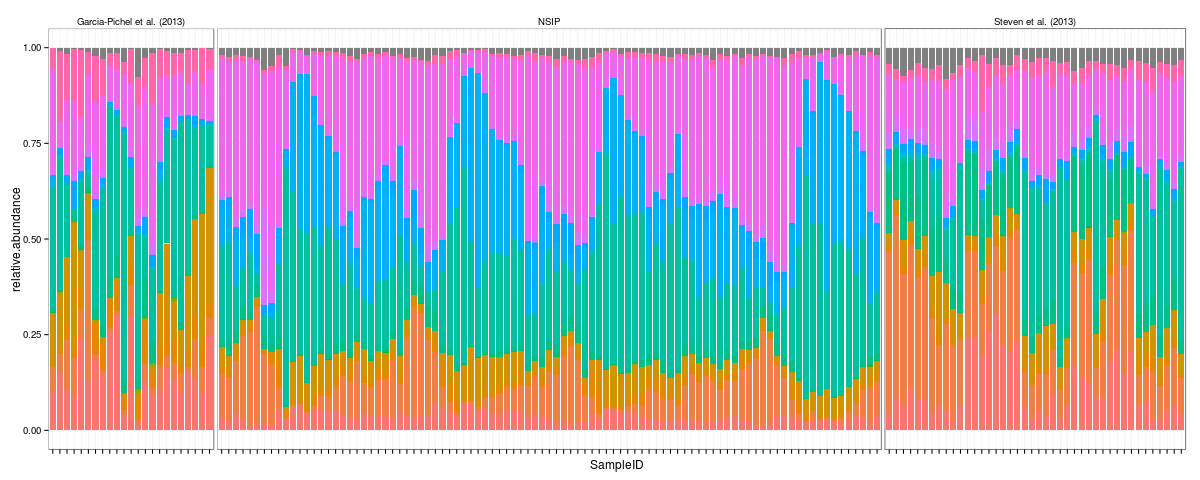

In [9]:
%%R -w 1200
d = mdf.dplyr %>%
    group_by(SampleID, Rank2) %>%
    filter(Abundance > 0) %>%
    summarize(rank2.abund = sum(Abundance), study = first(study)) %>%
    mutate(relative.abundance = rank2.abund / sum(rank2.abund))

p = ggplot(d, aes(x = SampleID, y = relative.abundance, fill = Rank2)) +
    facet_grid(.~study, drop = TRUE, space = "free", scales = "free") +
    geom_bar(stat = "identity", width = 0.85) + 
    theme_bw() + theme(axis.text.x = element_blank(), legend.position = "none", strip.background = element_blank())
p

Snap.

In [23]:
%%R
pckgs  = lapply(names(sessionInfo()$otherPkgs), packageVersion)
names(pckgs) = names(sessionInfo()$otherPkgs)
data.frame(pckgs)

  ggplot2 magrittr tidyr dplyr phyloseq
1   1.0.0      1.5 0.2.0 0.4.1   1.9.15
